In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import zarr
import numpy as np
import torch
from pathlib import Path
import matplotlib.pyplot as plt

# Import scipy norm function
from scipy.linalg import norm

from src.dataset import get_normalizer
from src.dataset.normalizer import Normalizer
from src.common.geometry import np_rot_6d_to_rotvec, np_rotvec_to_rot_6d

## Debug teleop delta action problems

In [3]:
normalize: Normalizer = get_normalizer(normalizer_type="min_max", control_mode="delta")

In [11]:
teleop = zarr.open(
    "/data/scratch/ankile/furniture-data/processed/sim/one_leg/teleop/low/success.zarr",
    mode="r",
)

scripted = zarr.open(
    "/data/scratch/ankile/furniture-data/processed/sim/one_leg/scripted/low/success.zarr",
    mode="r",
)

In [12]:
list(teleop.keys()), teleop["action/delta"].shape

(['action',
  'color_image1',
  'color_image2',
  'episode_ends',
  'furniture',
  'parts_poses',
  'pickle_file',
  'reward',
  'robot_state',
  'skill',
  'success'],
 (29020, 10))

In [13]:
# Get the relevant data for the teleop and scripted data
# Teleop
t_episode_ends = teleop["episode_ends"][:]
t_deltas = teleop["action/delta"][:]
t_pos = teleop["action/pos"][:]

# Split into episodes
t_ep_delta = np.split(t_deltas, t_episode_ends[:-1])
t_ep_pos = np.split(t_pos, t_episode_ends[:-1])

# Scripted
s_episode_ends = scripted["episode_ends"][:]
s_deltas = scripted["action/delta"][:]
s_pos = scripted["action/pos"][:]

# Split into episodes
s_ep_delta = np.split(s_deltas, s_episode_ends[:-1])
s_ep_pos = np.split(s_pos, s_episode_ends[:-1])

In [7]:
def plot_episode_rot_norm(
    episode: np.ndarray, demo_source: str, include_normalized: bool = False
):
    # Now we'll plot the norm of the delta positions and the delta rotations in the first row
    # and the normalized versions in the second row
    fig, ax = plt.subplots(
        nrows=(1 + int(include_normalized)),
        ncols=2,
        figsize=(16, 4 * (1 + int(include_normalized))),
        squeeze=False,
    )

    # Start with the raw values
    delta_pos_norm = norm(episode[:, :3], axis=1)
    delta_rot_norm = norm(np_rot_6d_to_rotvec(episode[:, 3:9]), axis=1)

    ax[0, 0].plot(delta_pos_norm, label="delta_pos_norm")
    ax[0, 1].plot(delta_rot_norm, label="delta_rot_norm")

    # Set labels
    ax[0, 0].set_title("delta_pos_norm")
    ax[0, 1].set_title("delta_rot_norm")

    # Now the normalized values
    if include_normalized:
        normalized_delta = normalize(episode, key="action", forward=True)
        delta_pos_norm = norm(normalized_delta[:, :3], axis=1)
        delta_rot_norm = norm(np_rot_6d_to_rotvec(normalized_delta[:, 3:9]), axis=1)

        ax[1, 0].plot(delta_pos_norm, label="normalized_delta_pos_norm")
        ax[1, 1].plot(delta_rot_norm, label="normalized_delta_rot_norm")

        # Set labels
        ax[1, 0].set_title("normalized_delta_pos_norm")
        ax[1, 1].set_title("normalized_delta_rot_norm")

    fig.suptitle(f"Norm of delta positions and rotations for {demo_source} episode")

## Plot delta actions

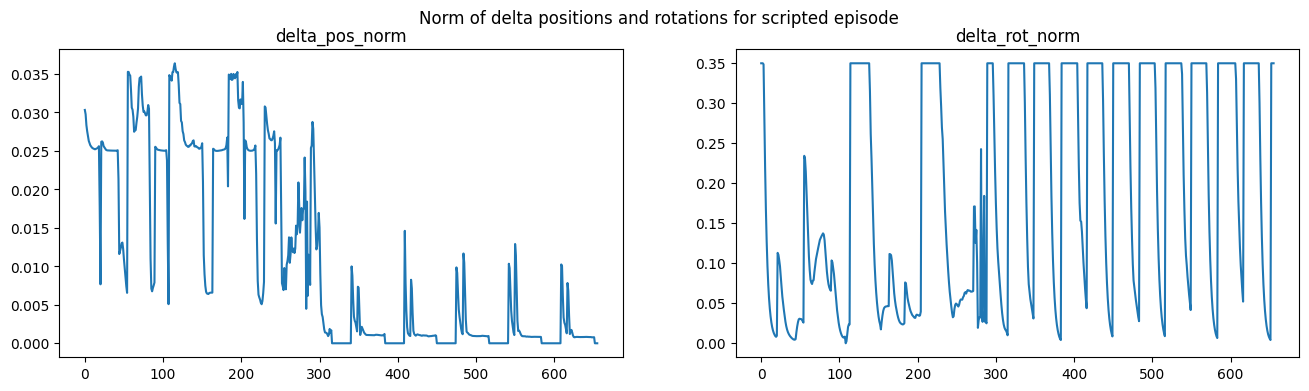

In [32]:
# Run the plot function for one episode of scripted
plot_episode(s_ep_delta[0], "scripted")

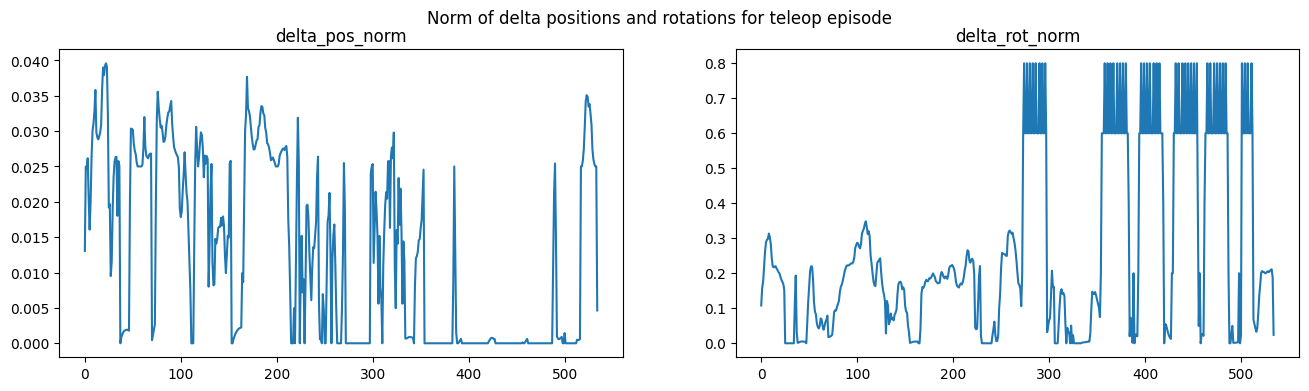

In [33]:
# Run the plot function for the first episode
plot_episode(t_ep_delta[0], "teleop")

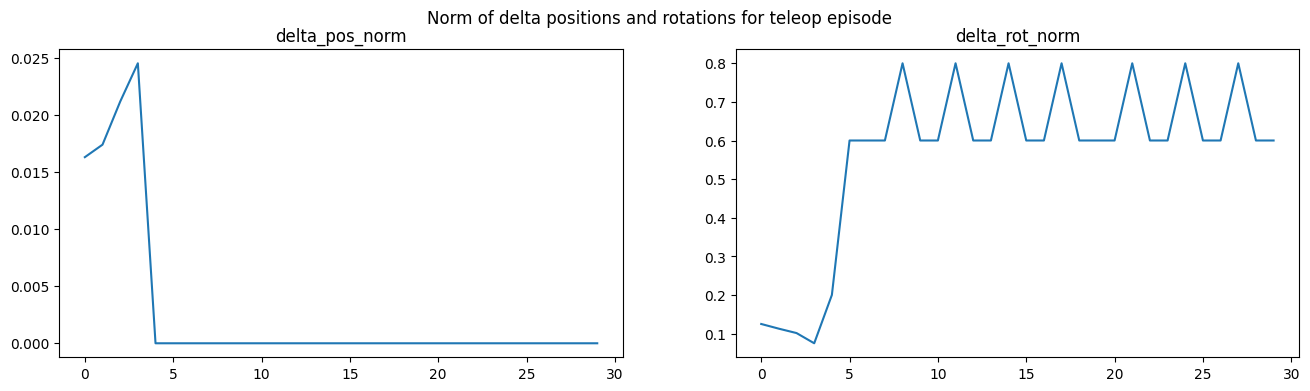

In [36]:
# Let's zoom in in the timesteps between 350 and 380
plot_episode(t_ep_delta[0][350:380], "teleop")

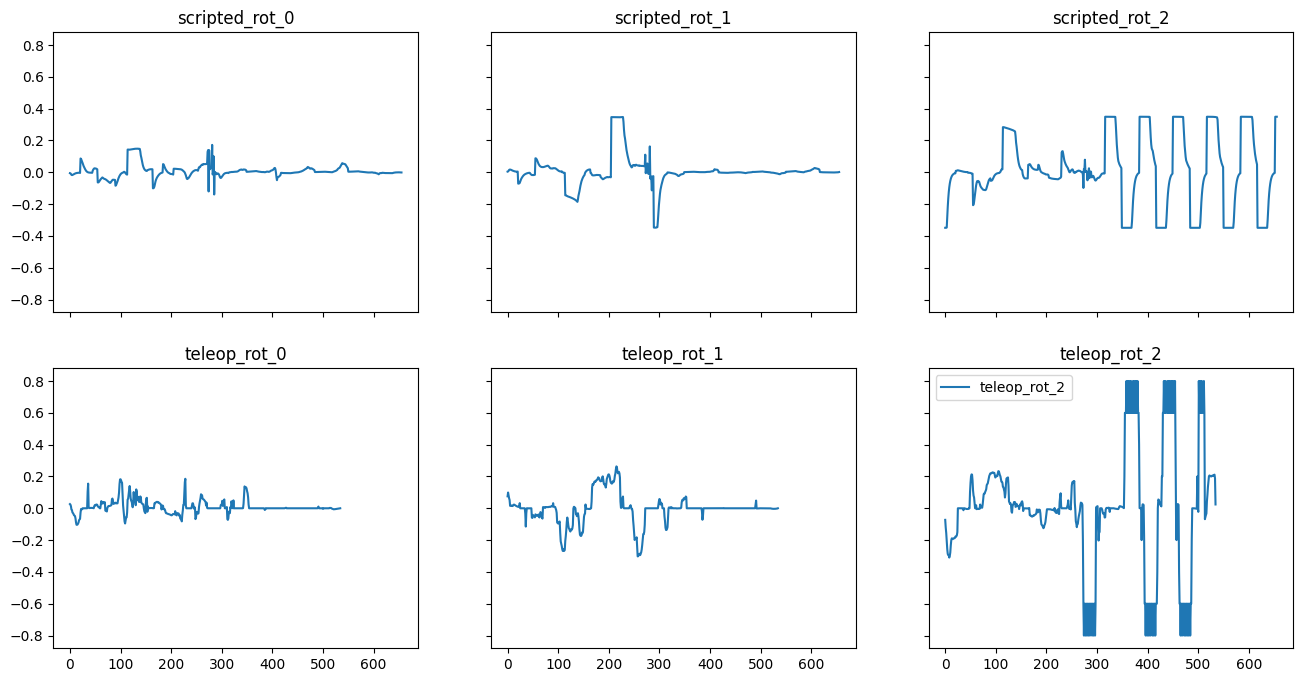

In [43]:
# Plot the values of the raw rotation vector coordinates for the first episode
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 8), sharex=True, sharey=True)

for i in range(3):
    ax[0, i].plot(
        np_rot_6d_to_rotvec(s_ep_delta[0][:, 3:9])[:, i], label=f"scripted_rot_{i}"
    )
    ax[0, i].set_title(f"scripted_rot_{i}")

    ax[1, i].plot(
        np_rot_6d_to_rotvec(t_ep_delta[0][:, 3:9])[:, i], label=f"teleop_rot_{i}"
    )
    ax[1, i].set_title(f"teleop_rot_{i}")

## Plot absolute actions

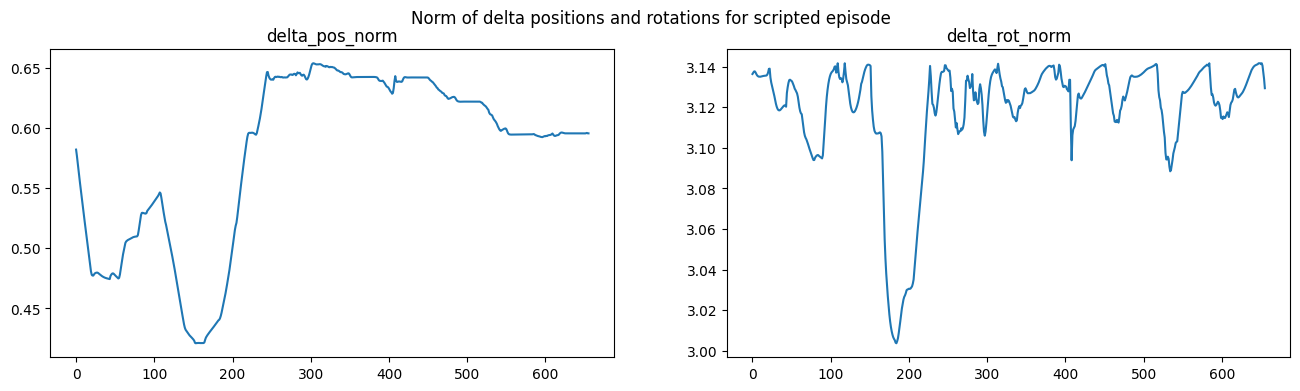

In [15]:
plot_episode(s_ep_pos[0], "scripted")

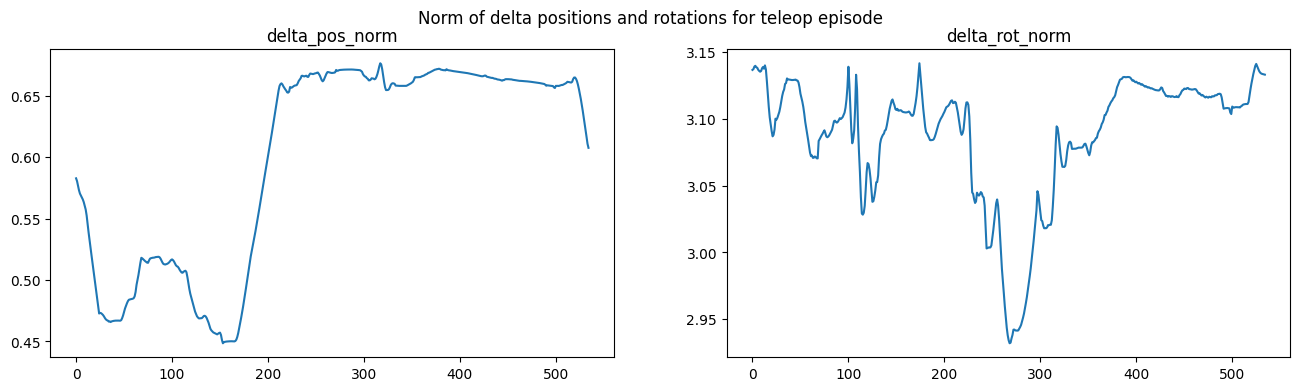

In [16]:
plot_episode(t_ep_pos[0], "teleop")

## clip the z-rotation as a band-aid fix

In [3]:
teleop = zarr.open(
    "/data/scratch/ankile/furniture-data/processed/sim/one_leg/teleop/low/success.zarr",
    mode="a",
)

In [4]:
# Define the clipping magnitude
clip_mag = 0.35

# Get the delta actions
teleop_deltas = teleop["action/delta"][:]

# Convert to rotation vectors
teleop_rotvecs = np_rot_6d_to_rotvec(teleop_deltas[:, 3:9])

# Clip the z-axis of the magnitude of the rotation vectors
teleop_rotvecs[:, 2] = np.clip(teleop_rotvecs[:, 2], -clip_mag, clip_mag)

# Convert back to 6D
teleop_deltas[:, 3:9] = np_rotvec_to_rot_6d(teleop_rotvecs)

# Save the changes
teleop["action/delta"] = teleop_deltas

In [6]:
# Teleop
t_episode_ends = teleop["episode_ends"][:]
t_deltas = teleop["action/delta"][:]
t_pos = teleop["action/pos"][:]

# Split into episodes
t_ep_delta = np.split(t_deltas, t_episode_ends[:-1])
t_ep_pos = np.split(t_pos, t_episode_ends[:-1])

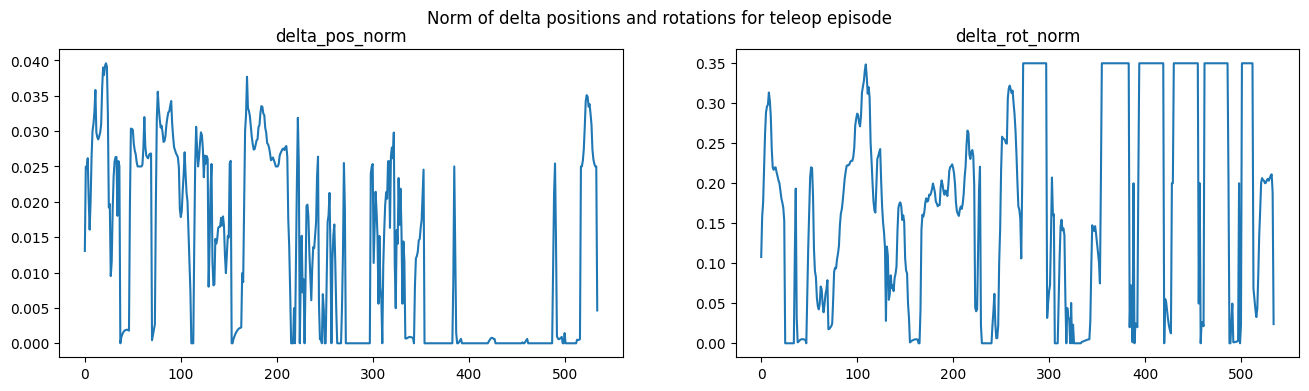

In [9]:
# Plot the teleop episode again
plot_episode(t_ep_delta[0], "teleop")

## Debug the absolute position actions

In [18]:
normalize: Normalizer = get_normalizer(normalizer_type="min_max", control_mode="pos")

In [22]:
teleop = zarr.open(
    "/data/scratch/ankile/furniture-data/processed/sim/one_leg/teleop/low/success.zarr",
    mode="r",
)

scripted = zarr.open(
    "/data/scratch/ankile/furniture-data/processed/sim/one_leg/scripted/low/success.zarr",
    mode="r",
)

print(list(teleop.keys()))

['action', 'color_image1', 'color_image2', 'episode_ends', 'furniture', 'parts_poses', 'pickle_file', 'reward', 'robot_state', 'skill', 'success']


In [23]:
ep_ends = teleop["episode_ends"][:]
# xyz = normalize(teleop["action/pos"][:], key="action")[:, :3]
actions = teleop["action/pos"][:]
xyz = actions[:, :3]

# Split into episodes
ep_actions = np.split(actions, ep_ends[:-1])
ep_xyz = np.split(xyz, ep_ends[:-1])

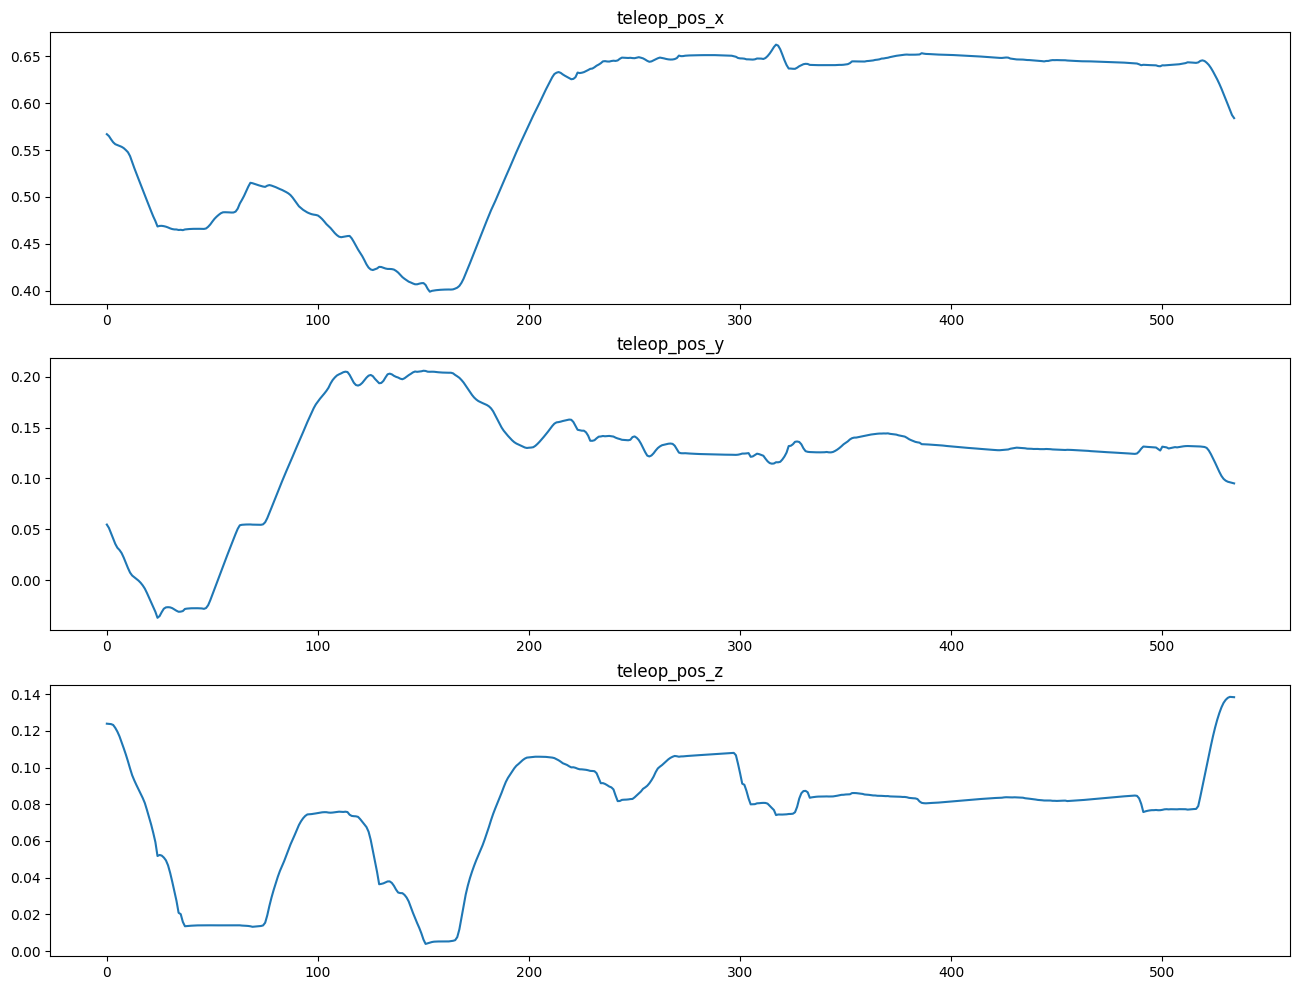

In [5]:
# Plot the x, y, and z coordinates of the position for the first episode in separate plots
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(16, 12))

for i, axis in enumerate(["x", "y", "z"]):
    ax[i].plot(ep_xyz[0][:, i], label=f"teleop_pos_{i}")
    ax[i].set_title(f"teleop_pos_{axis}")

In [4]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


def plot_3d_episode(ep_xyz: np.ndarray):
    # Extracting x, y, z coordinates
    x, y, z = ep_xyz[:, 0], ep_xyz[:, 1], ep_xyz[:, 2]

    # Creating a 3D plot
    fig = plt.figure(figsize=(16, 12))
    ax = fig.add_subplot(111, projection="3d")

    # Creating a color map based on the time progression
    colors = plt.cm.jet(np.linspace(0, 1, len(x)))

    # Plotting the line with color gradient
    for i in range(len(x) - 1):
        ax.plot(x[i : i + 2], y[i : i + 2], z[i : i + 2], color=colors[i])

    # Optionally, plot the points as well to enhance the color visibility
    ax.scatter(x, y, z, color=colors, s=10)  # 's' is the size of the points

    # Showing the plot
    plt.show()

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from wandb import Api
import furniture_bench

api = Api()

from src.behavior import get_actor
from src.eval.rollout import rollout
from omegaconf import OmegaConf, DictConfig


from src.gym import get_env

import os
import zarr
import numpy as np
import torch
from pathlib import Path
import matplotlib.pyplot as plt

# Import scipy norm function
from scipy.linalg import norm

from src.dataset import get_normalizer
from src.dataset.normalizer import Normalizer
from src.common.geometry import np_rot_6d_to_rotvec, np_rotvec_to_rot_6d

Importing module 'gym_38' (/data/scratch/ankile/isaacgym/python/isaacgym/_bindings/linux-x86_64/gym_38.so)
Setting GYM_USD_PLUG_INFO_PATH to /data/scratch/ankile/isaacgym/python/isaacgym/_bindings/linux-x86_64/usd/plugInfo.json
PyTorch version 2.0.1+cu117
Device count 1
/data/scratch/ankile/isaacgym/python/isaacgym/_bindings/src/gymtorch


Using /data/scratch/ankile/.cache as PyTorch extensions root...
Emitting ninja build file /data/scratch/ankile/.cache/gymtorch/build.ninja...
Building extension module gymtorch...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module gymtorch...


In [4]:
env = get_env(
    act_rot_repr="rot_6d",
    action_type="pos",
    ctrl_mode="osc",
    furniture="one_leg",
    gpu_id=0,
    max_env_steps=1000,
    num_envs=1,
    randomness="low",
    resize_img=False,
    verbose=False,
    headless=False,
)

In [5]:
normalize: Normalizer = get_normalizer(normalizer_type="min_max", control_mode="pos")

In [6]:
# Load in a model and roll out a policy
# run = api.run("robot-rearrangement/baselines/runs/bldvh98n")
# run = api.run("robot-rearrangement/baselines/runs/agp4fii6")
run = api.run("robot-rearrangement/baselines/runs/cmldtuvh")

# Load in the model
model_file = [f for f in run.files() if f.name.endswith(".pt")][0]
model_file.download(replace=True)

# Print the time of last modification
print(model_file.updated_at)

cfg = OmegaConf.create(run.config)

act = get_actor(
    config=cfg,
    device="cuda",
    normalizer=normalize,
)

act.load_state_dict(torch.load(model_file.name))

2024-02-04T21:08:09


/data/scratch/ankile/miniconda3/envs/rlgpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Total parameters: 102.78M
normalizer: 0.00M parameters
encoder1: 11.19M parameters
encoder2: 11.19M parameters
encoder1_proj: 0.02M parameters
encoder2_proj: 0.02M parameters
model: 80.36M parameters
loss_fn: 0.00M parameters


<All keys matched successfully>

In [7]:
# Roll out the policy
robot_states, imgs1, imgs2, actions, rewards, parts_poses = rollout(
    actor=act,
    env=env,
    rollout_max_steps=1_000,
)

INFO: Found collision-free init pose


KeyboardInterrupt: 

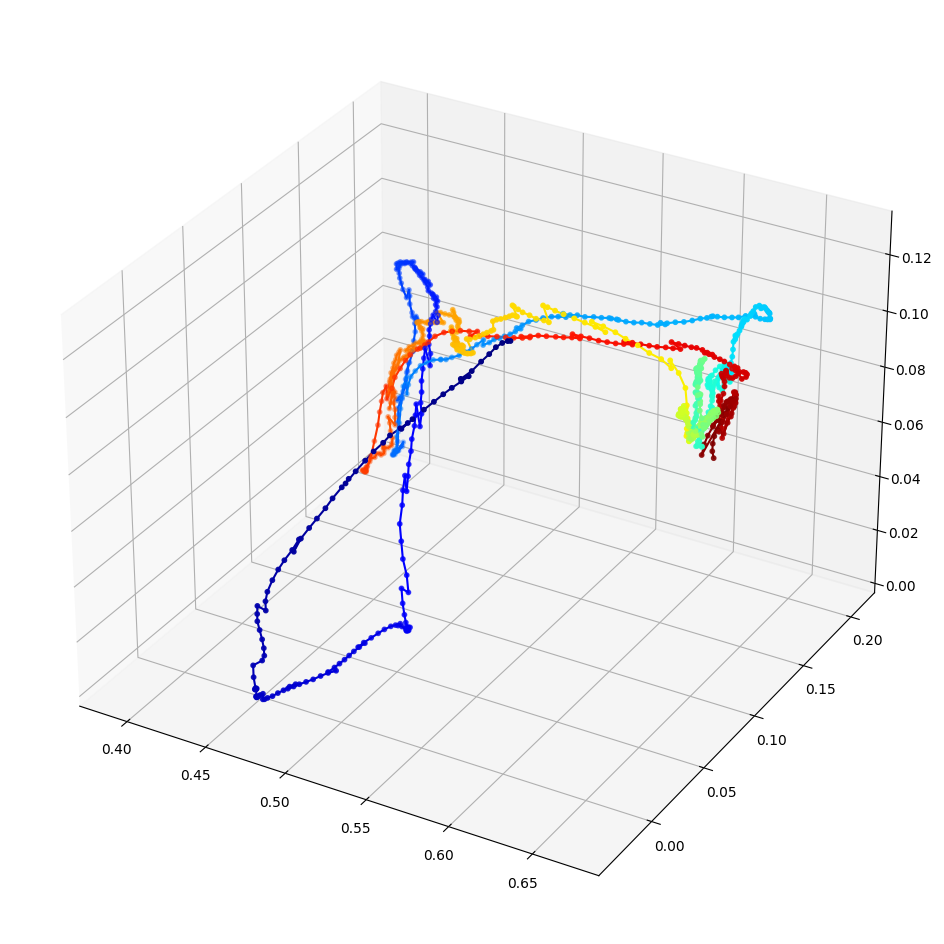

In [ ]:
# Plot the resulting trajectory
plot_3d_episode(actions[0].cpu().numpy())

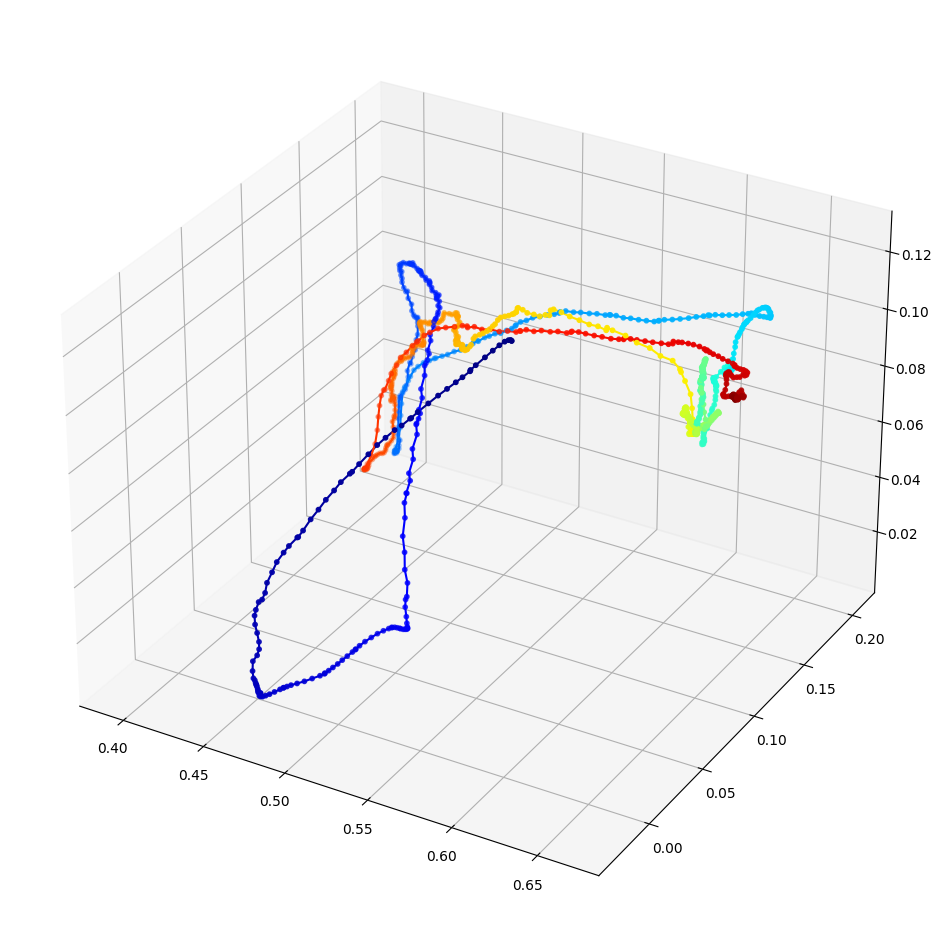

In [9]:
# Plot the resulting trajectory
plot_3d_episode(robot_states[0].cpu().numpy())

# Look at the scripted demos

In [25]:
s_ep_ends = scripted["episode_ends"][:]
# xyz = normalize(teleop["action/pos"][:], key="action")[:, :3]
s_actions = scripted["action/pos"][:]

# Split into episodes
s_ep_actions = np.split(s_actions, s_ep_ends[:-1])

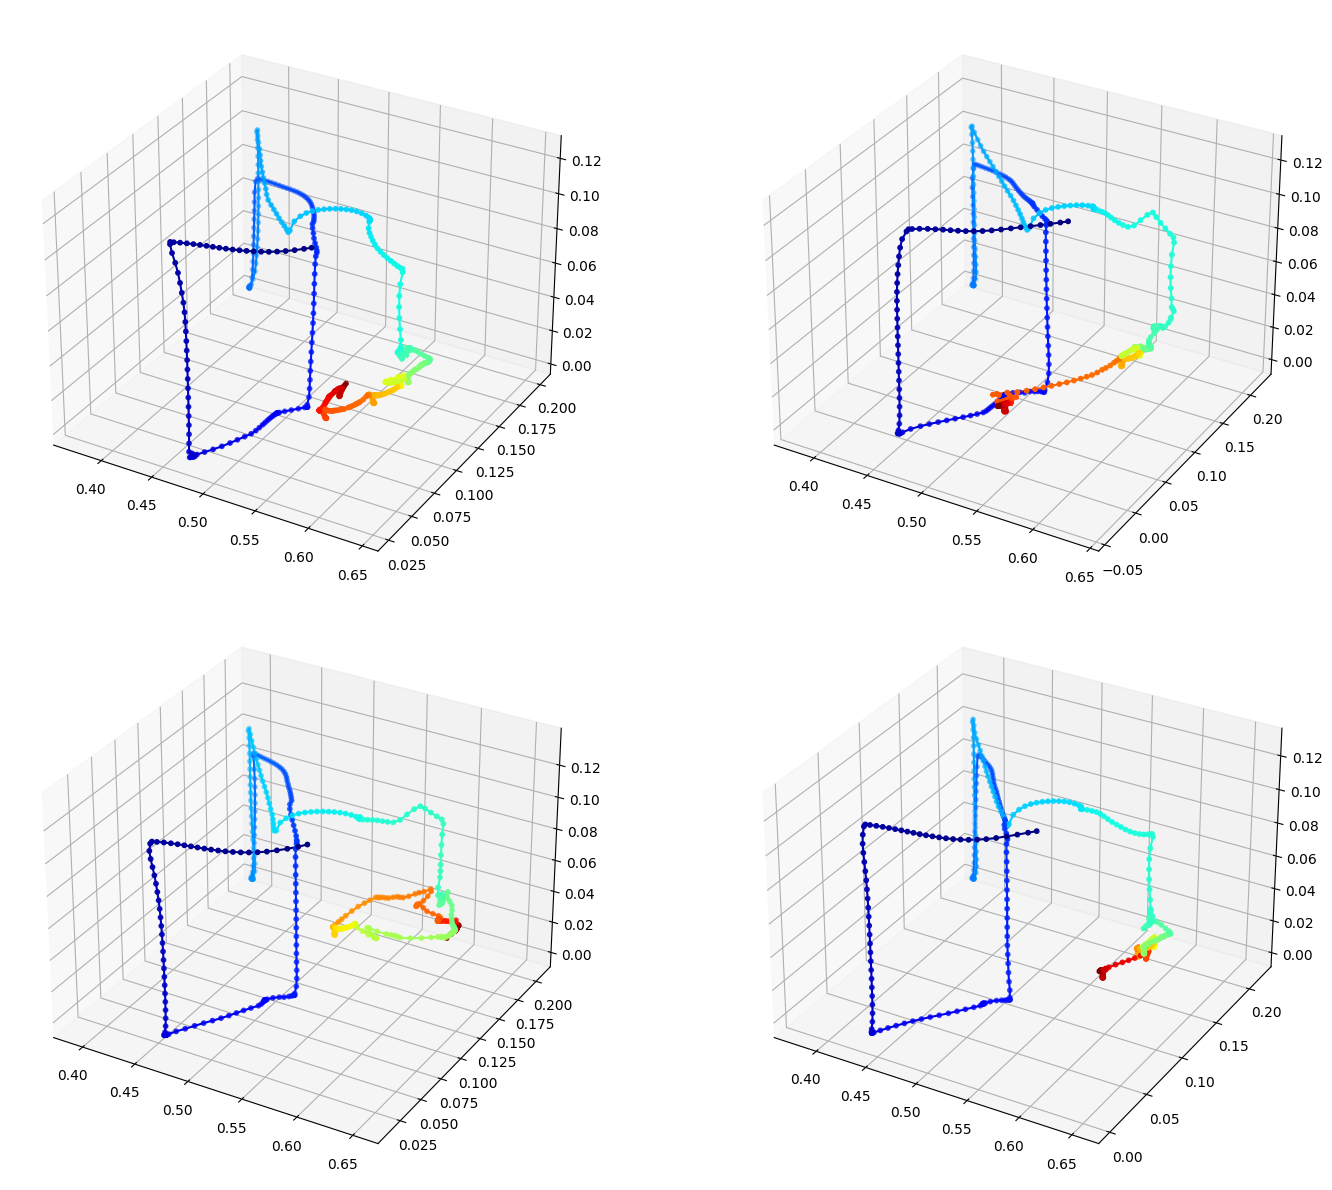

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def plot_3d_episode(xyz: np.ndarray, ax):
    # Extracting x, y, z coordinates
    x, y, z = xyz[:, 0], xyz[:, 1], xyz[:, 2]

    # Creating a color map based on the time progression
    colors = plt.cm.jet(np.linspace(0, 1, len(x)))

    # Plotting the line with color gradient
    for i in range(len(x) - 1):
        ax.plot(x[i : i + 2], y[i : i + 2], z[i : i + 2], color=colors[i])

    # Optionally, plot the points as well to enhance the color visibility
    ax.scatter(x, y, z, color=colors, s=10)


# Main code to create subplots for multiple episodes
def plot_multiple_eps(ep_actions, num_rows=2, num_cols=2):

    fig = plt.figure(figsize=(16, 12))

    for i in range(num_rows * num_cols):
        ax = fig.add_subplot(num_rows, num_cols, i + 1, projection="3d")
        # Assuming episodes_data is a list of numpy arrays, each representing an episode
        ep_act = ep_actions[i]
        plot_3d_episode(ep_act, ax)

    plt.tight_layout()
    plt.show()


plot_multiple_eps(s_ep_actions, num_rows=2, num_cols=2)

In [27]:
normalize: Normalizer = get_normalizer(
    normalizer_type="min_max", control_mode="pos"
).cpu()

# Look at the same but normalized
s_nactions = normalize(s_actions, key="action", forward=True)

# Split into episodes
s_ep_nactions = np.split(s_nactions, s_ep_ends[:-1])

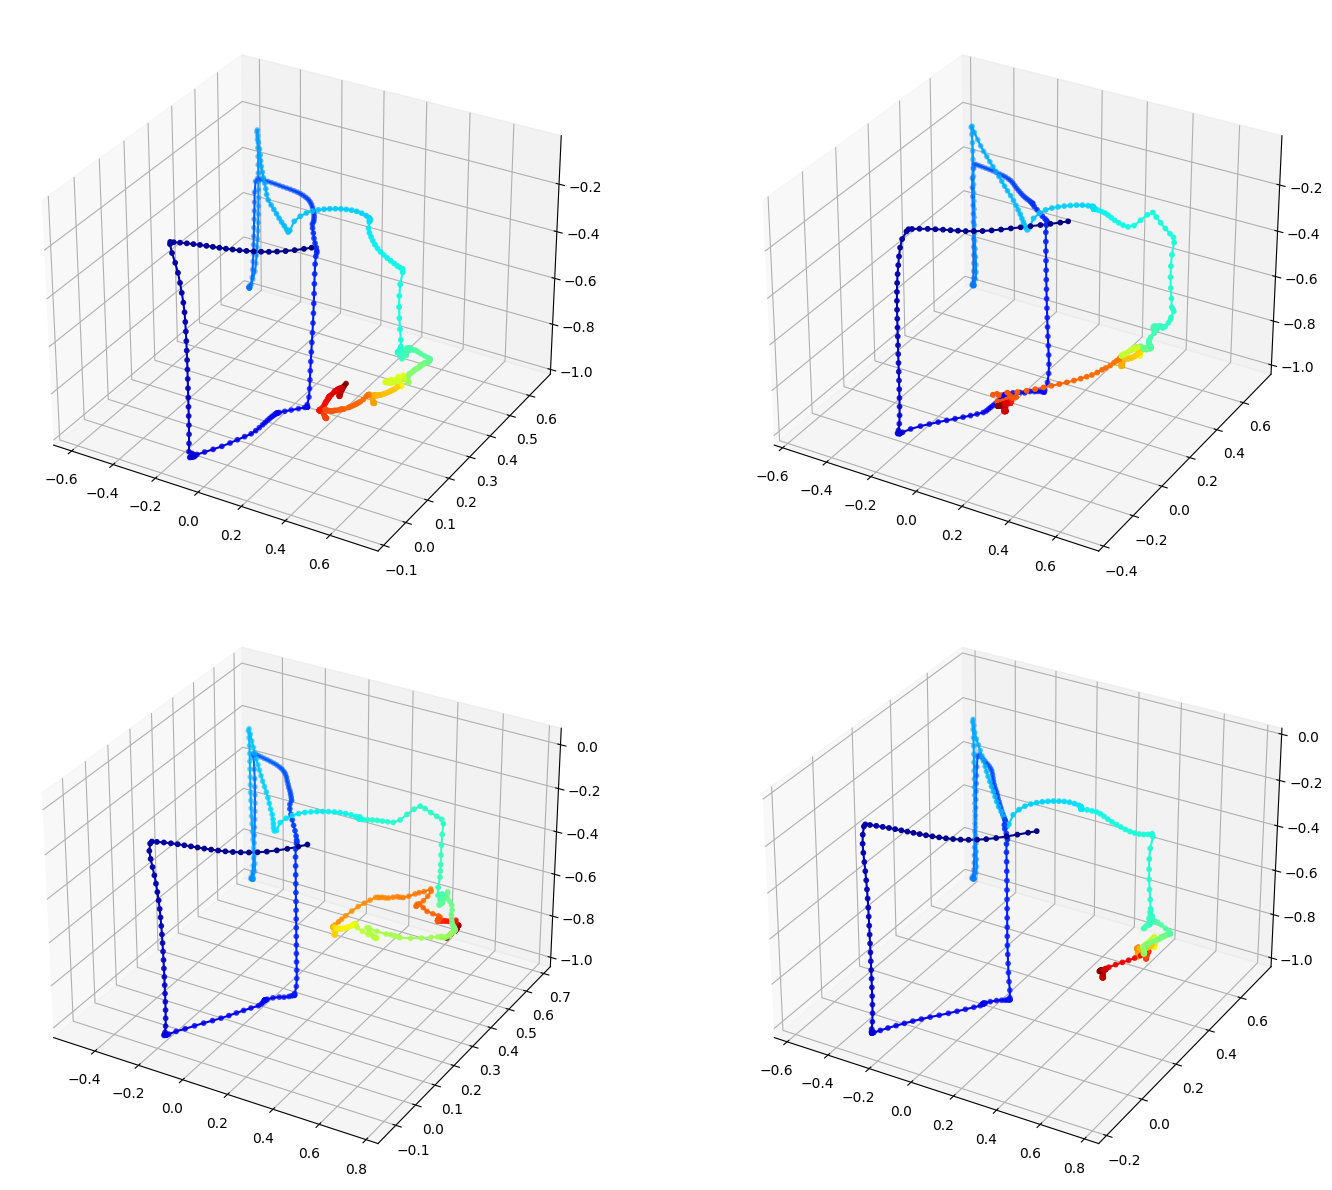

In [28]:
# Plot the normalized actions
plot_multiple_eps(s_ep_nactions, num_rows=2, num_cols=2)

In [33]:
s_nactions[:, :3].max()

0.81040335

In [38]:
scripted["action/pos"].shape, scripted["action/delta"].shape, scripted[
    "robot_state"
].shape, scripted["episode_ends"][-1]

((123905, 10), (123905, 10), (123905, 16), 123905)

## Verify that the new `lamp` demos are working

In [9]:
teleop = zarr.open(
    "/data/scratch/ankile/furniture-data/processed/sim/lamp/teleop/low/success.zarr",
    mode="r",
)

scripted = zarr.open(
    "/data/scratch/ankile/furniture-data/processed/sim/lamp/scripted/low/success.zarr",
    mode="r",
)

print(list(teleop.keys()))
print(list(scripted.keys()))

# Get teleop episodes
t_ep_ends = teleop["episode_ends"][:]
t_actions = teleop["action/pos"][:]
t_ep_actions = np.split(actions, ep_ends[:-1])

# Get scripted episodes
s_ep_ends = scripted["episode_ends"][:]
s_actions = scripted["action/pos"][:]
s_ep_actions = np.split(s_actions, s_ep_ends[:-1])

['action', 'color_image1', 'color_image2', 'episode_ends', 'furniture', 'parts_poses', 'pickle_file', 'reward', 'robot_state', 'skill', 'success']
['action', 'color_image1', 'color_image2', 'episode_ends', 'furniture', 'parts_poses', 'pickle_file', 'reward', 'robot_state', 'skill', 'success']


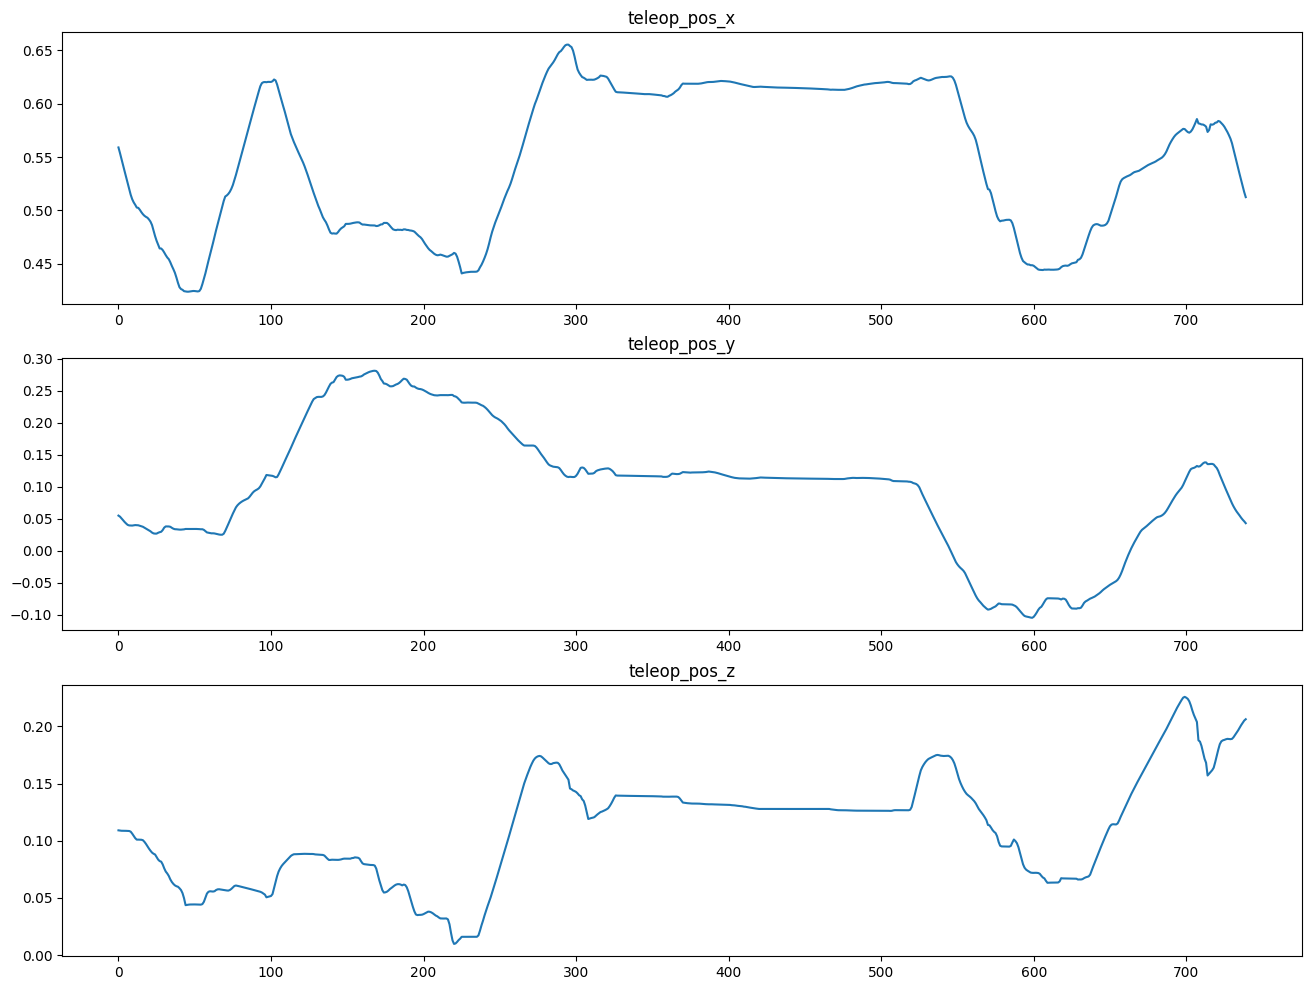

In [10]:
# Plot the x, y, and z coordinates of the position for the first episode in separate plots
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(16, 12))

for i, axis in enumerate(["x", "y", "z"]):
    ax[i].plot(ep_actions[0][:, i], label=f"teleop_pos_{i}")
    ax[i].set_title(f"teleop_pos_{axis}")

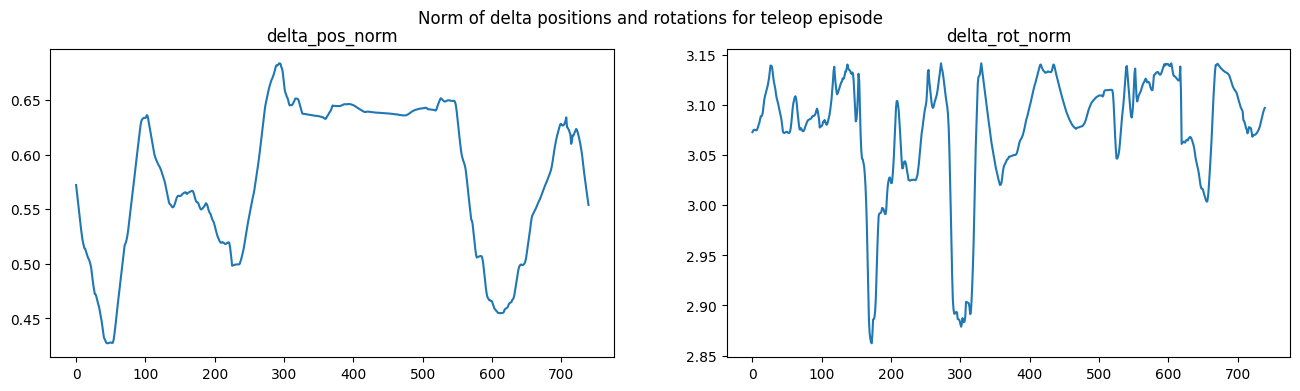

In [11]:
plot_episode_rot_norm(ep_actions[0], "teleop")

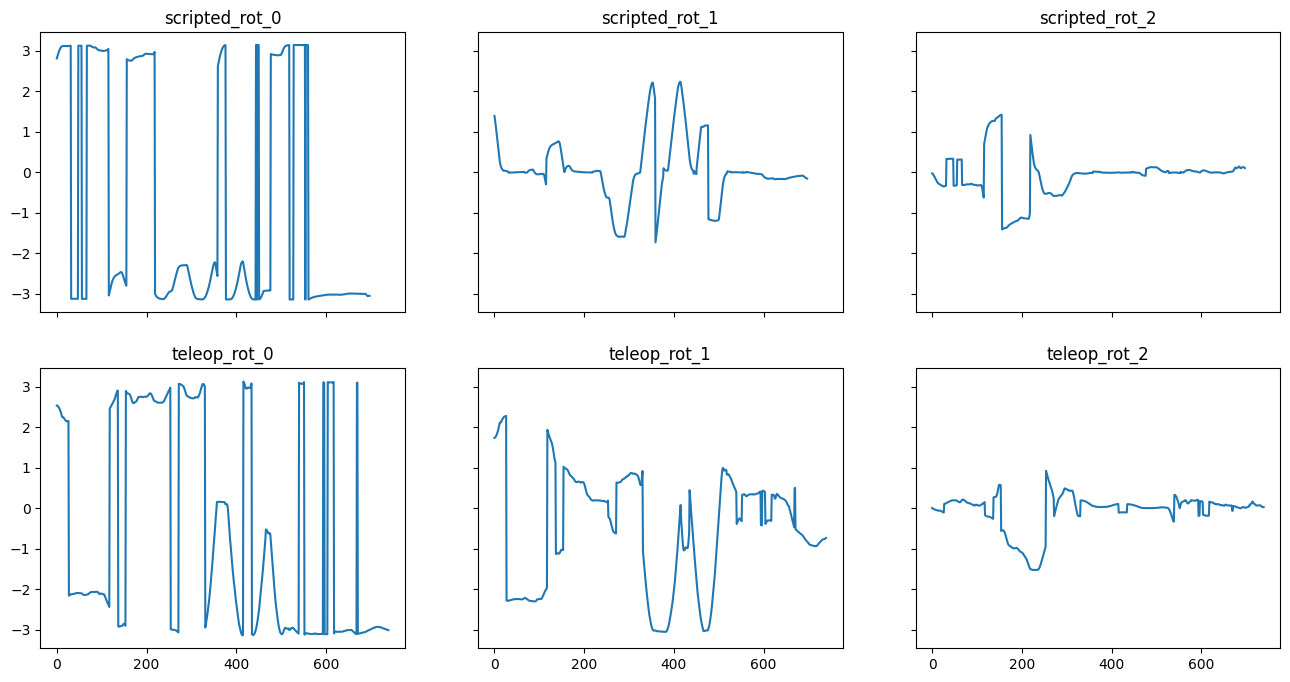

In [12]:
# Plot the values of the raw rotation vector coordinates for the first episode
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 8), sharex=True, sharey=True)

for i in range(3):
    ax[0, i].plot(
        np_rot_6d_to_rotvec(s_ep_actions[0][:, 3:9])[:, i], label=f"scripted_rot_{i}"
    )
    ax[0, i].set_title(f"scripted_rot_{i}")

    ax[1, i].plot(
        np_rot_6d_to_rotvec(t_ep_actions[0][:, 3:9])[:, i], label=f"teleop_rot_{i}"
    )
    ax[1, i].set_title(f"teleop_rot_{i}")

## Look at action values across the dataset to verify normalization limits

In [3]:
from src.common.files import get_processed_paths

In [62]:
zarr_files = get_processed_paths(
    environment="sim",
    # task="one_leg",
    task=None,
    demo_outcome="success",
    demo_source=["teleop", "scripted"],
    randomness=None,
)

Found the following paths:
    /data/scratch/ankile/furniture-data/processed/sim/one_leg/teleop/low/success.zarr
    /data/scratch/ankile/furniture-data/processed/sim/lamp/teleop/low/success.zarr
    /data/scratch/ankile/furniture-data/processed/sim/square_table/teleop/med/success.zarr
    /data/scratch/ankile/furniture-data/processed/sim/square_table/teleop/low/success.zarr
    /data/scratch/ankile/furniture-data/processed/sim/one_leg/scripted/low/success.zarr
    /data/scratch/ankile/furniture-data/processed/sim/one_leg/scripted/med/success.zarr
    /data/scratch/ankile/furniture-data/processed/sim/lamp/scripted/low/success.zarr
    /data/scratch/ankile/furniture-data/processed/sim/lamp/scripted/med/success.zarr
    /data/scratch/ankile/furniture-data/processed/sim/round_table/scripted/med/success.zarr
    /data/scratch/ankile/furniture-data/processed/sim/round_table/scripted/low/success.zarr


In [63]:
normalizer: Normalizer = get_normalizer(normalizer_type="min_max", control_mode="delta")
standardizer: Normalizer = get_normalizer(
    normalizer_type="mean_std", control_mode="delta"
)

In [64]:
# Make a big pandas dataframe with all the action data
import pandas as pd
from tqdm import tqdm

# Create a list of dataframes
action_dfs = []

# Loop through the zarr files
for zarr_file in tqdm(zarr_files):
    # Open the zarr file
    zarr_data = zarr.open(zarr_file, mode="r")

    # Get the episode ends
    episode_ends = zarr_data["episode_ends"][:]

    # Get the actions
    actions = zarr_data["action/pos"][:]

    # Split into episodes
    ep_actions = np.split(actions, episode_ends[:-1])

    # Action names
    act_names = ["x", "y", "z", "r1", "r2", "r3", "r4", "r5", "r6", "gripper"]

    # Create a dataframe
    action_df = pd.DataFrame(
        {name: zarr_data["action/delta"][:, i] for i, name in enumerate(act_names)}
    )

    # # Add the pickle file name
    # for idx, name in zip(episode_ends[:], zarr_data["pickle_file"][:]):
    #     action_df.loc[idx - 1, "pickle_file"] = name

    # # Backfill the pickle file name
    # action_df["pickle_file"] = action_df["pickle_file"].bfill()

    # Append to the list
    action_dfs.append(action_df)

# Concatenate the dataframes
action_df = pd.concat(action_dfs)

action_df.head()

100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


,x,y,z,r1,r2,r3,r4,r5,r6,gripper
0,-0.00848,-0.00992,0.00000,0.994532,0.073606,0.074088,-0.071635,0.997011,-0.028927,-1.0
1,-0.01600,-0.01920,0.00000,0.987803,0.121667,0.097169,-0.119416,0.992430,-0.028676,-1.0
2,-0.01248,-0.02128,0.00000,0.984648,0.155353,0.079586,-0.154301,0.987836,-0.019241,-1.0
3,-0.01008,-0.02336,-0.00608,0.976498,0.205839,0.063887,-0.206351,0.978477,0.001457,-1.0
4,0.00000,-0.01840,-0.00880,0.965998,0.253099,0.052810,-0.253678,0.967279,0.004443,-1.0


In [65]:
# Calculate the min and max values for each action
action_df.agg(["min", "max"])

,x,y,z,r1,r2,r3,r4,r5,r6,gripper
min,-0.025,-0.025,-0.025,0.939373,-0.342898,-0.342019,-0.342898,0.939373,-0.333489,-1.0
max,0.025,0.025,0.040,1.000000,0.342898,0.342020,0.342898,1.000000,0.337430,1.0


In [66]:
# Normalize and standardize the actions
normalized_actions = normalizer(action_df, key="action", forward=True)
standardized_actions = standardizer(action_df, key="action", forward=True)

In [67]:
normalized_actions.agg(["min", "max"])

,x,y,z,r1,r2,r3,r4,r5,r6,gripper
min,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.059028,-1.0
max,1.0,1.0,1.6,1.0,1.0,1.0,1.0,1.0,1.038961,1.0


In [68]:
standardized_actions.agg(["min", "max"])

,x,y,z,r1,r2,r3,r4,r5,r6,gripper
min,-2.545030,-2.996397,-2.211174,-1.226621,-1.534694,-4.376727,-1.685655,-1.331737,-8.461342,-1.074395
max,2.471618,2.947889,3.345629,0.961967,1.684386,4.385010,1.539305,0.878655,8.457621,0.929136


Text(0.5, 0.98, 'Histograms of the actions no normalization for')

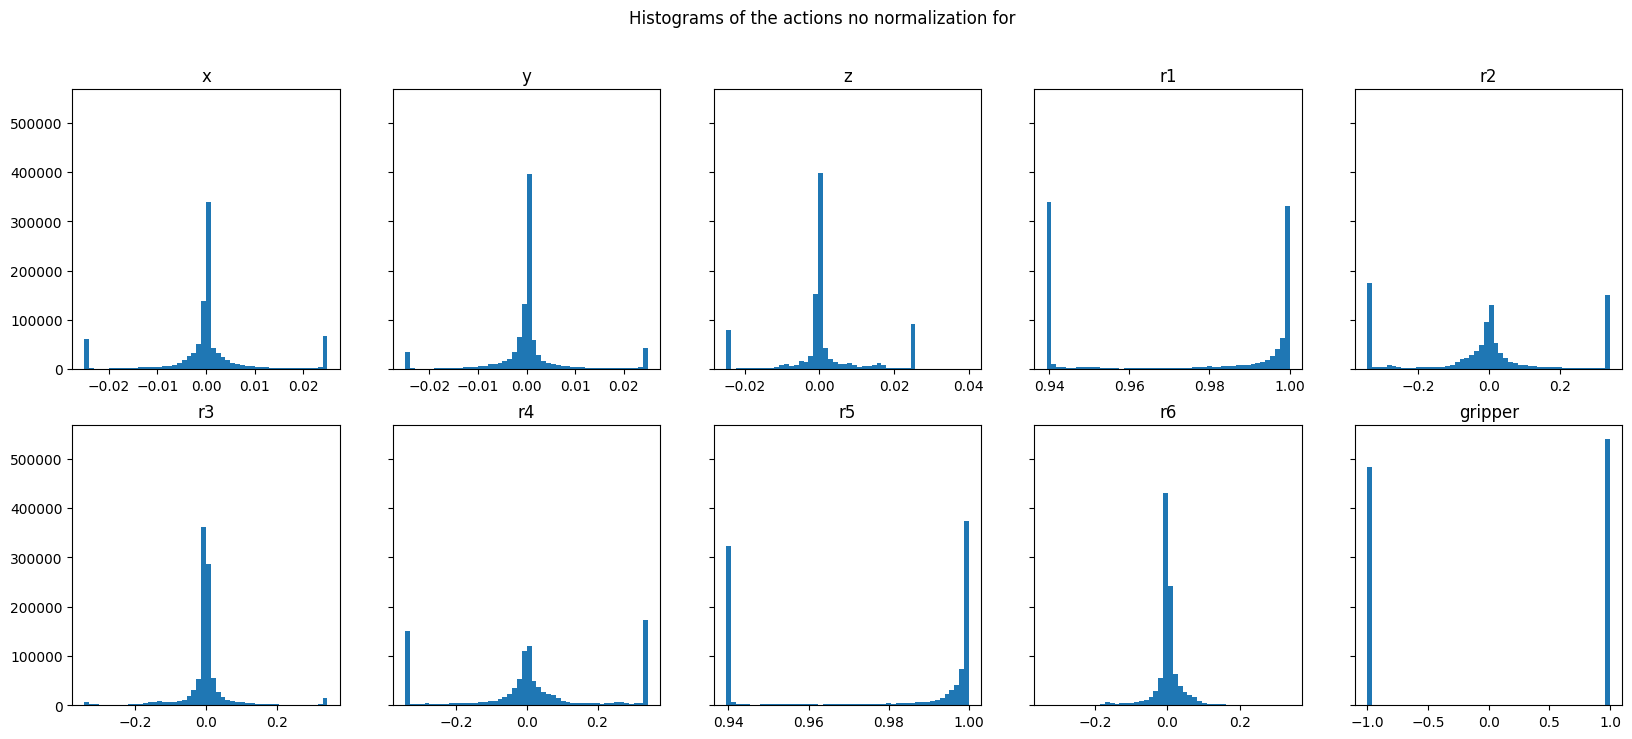

In [69]:
# Make histograms for each of the actions
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 8), sharey=True)

for i, name in enumerate(act_names):
    ax[i // 5, i % 5].hist(action_df[name], bins=50)
    ax[i // 5, i % 5].set_title(name)

fig.suptitle("Histograms of the actions no normalization for")

Text(0.5, 0.98, 'Histograms of the actions normalized')

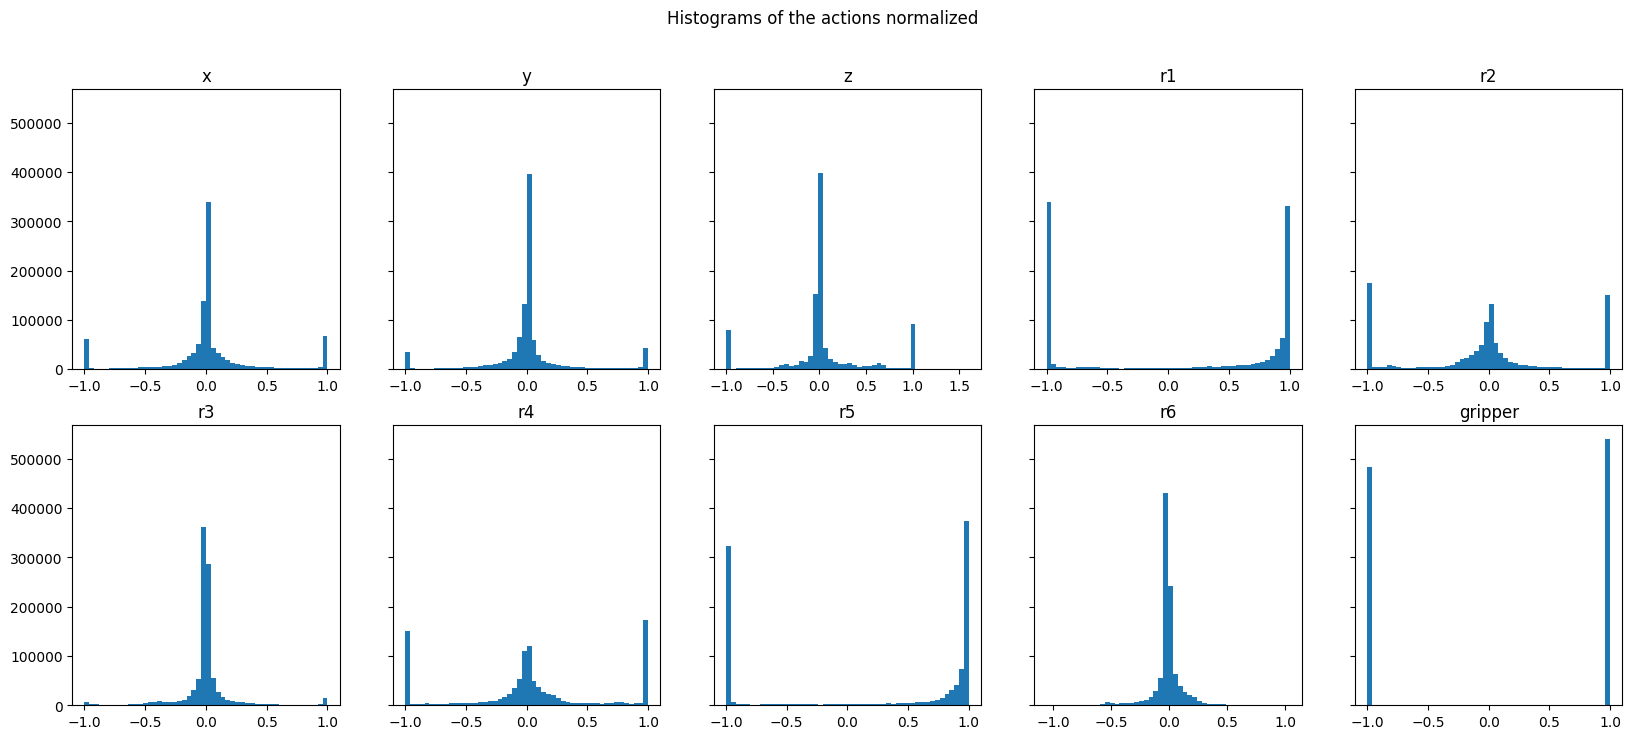

In [70]:
# Make histograms for each of the actions normalized
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 8), sharey=True)

for i, name in enumerate(act_names):
    ax[i // 5, i % 5].hist(normalized_actions[name], bins=50)
    ax[i // 5, i % 5].set_title(name)

fig.suptitle("Histograms of the actions normalized")

Text(0.5, 0.98, 'Histograms of the actions standardized')

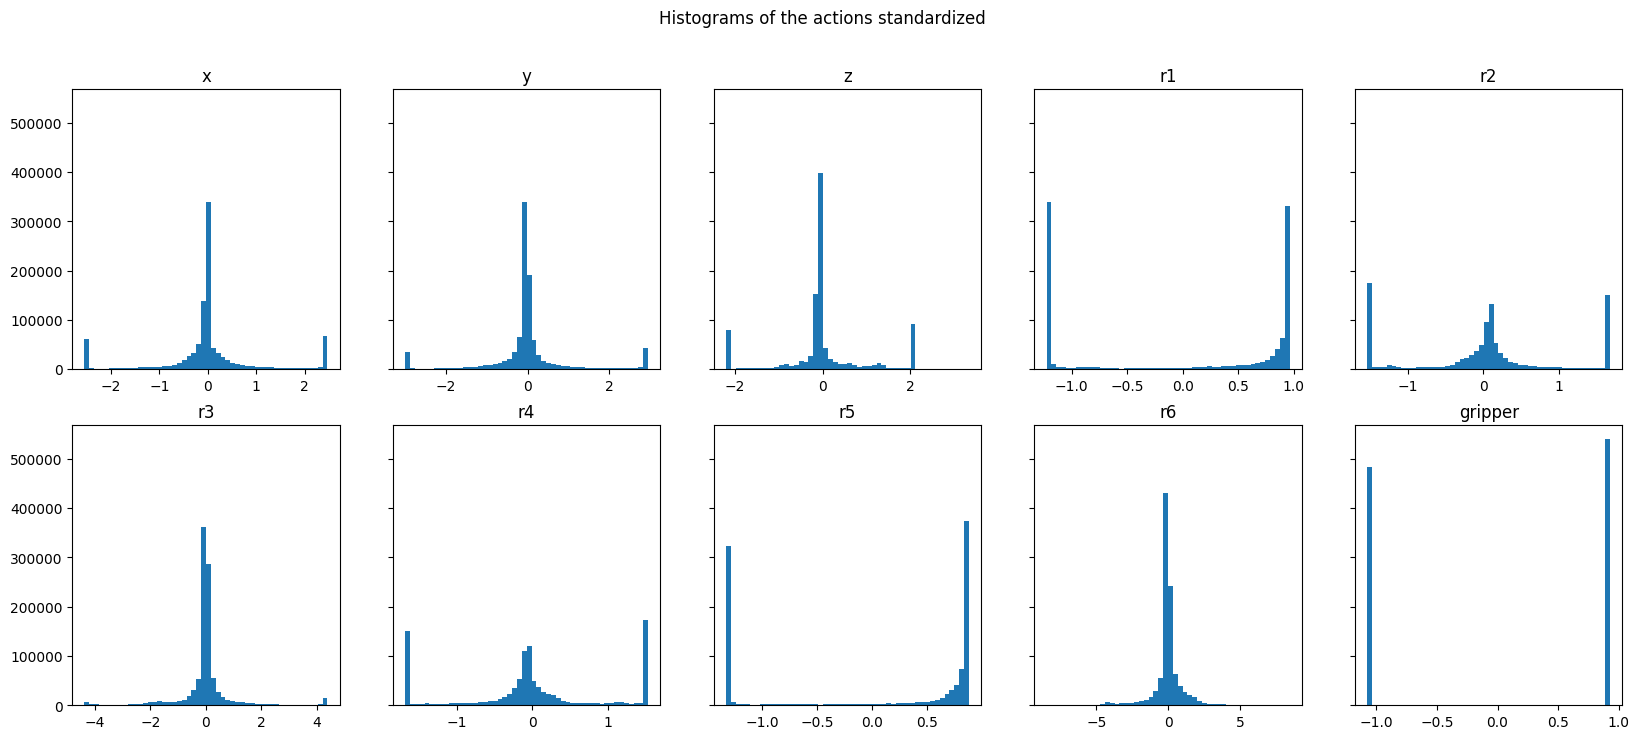

In [71]:
# Make histograms for each of the actions standardized
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 8), sharey=True)

for i, name in enumerate(act_names):
    ax[i // 5, i % 5].hist(standardized_actions[name], bins=50)
    ax[i // 5, i % 5].set_title(name)

fig.suptitle("Histograms of the actions standardized")

In [72]:
# Also do the same for the position

# Create a list of dataframes
state_dfs = []

# Loop through the zarr files
for zarr_file in tqdm(zarr_files):
    # Open the zarr file
    zarr_data = zarr.open(zarr_file, mode="r")

    # Get the episode ends
    episode_ends = zarr_data["episode_ends"][:]

    # Get the actions
    state = zarr_data["robot_state"][:]

    # Action names
    state_names = [
        "x",
        "y",
        "z",
        "r1",
        "r2",
        "r3",
        "r4",
        "r5",
        "r6",
        "dx",
        "dy",
        "dz",
        "drx",
        "dry",
        "drz",
        "gripper",
    ]

    # Create a dataframe
    state_df = pd.DataFrame({name: state[:, i] for i, name in enumerate(state_names)})

    # # Add the pickle file name
    # for idx, name in zip(episode_ends[:], zarr_data["pickle_file"][:]):
    #     state_df.loc[idx - 1, "pickle_file"] = name

    # # Backfill the pickle file name
    # state_df["pickle_file"] = state_df["pickle_file"].bfill()

    # Append to the list
    state_dfs.append(state_df)

# Concatenate the dataframes
state_df = pd.concat(state_dfs)

state_df.head()

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 13.10it/s]


,x,y,z,r1,r2,r3,r4,r5,r6,dx,dy,dz,drx,dry,drz,gripper
0,0.567280,0.055427,0.123922,0.595977,0.802914,-0.011870,0.802827,-0.596091,-0.012046,2.209546e-07,-8.063197e-08,2.622709e-07,4.457632e-07,-7.843252e-07,-0.000002,0.065
1,0.566822,0.054659,0.123900,0.596095,0.802819,-0.012353,0.802737,-0.596216,-0.011798,-1.836815e-02,-3.712124e-02,-1.063437e-03,-1.566794e-02,2.209980e-02,-0.056139,0.065
2,0.564778,0.051296,0.123802,0.596350,0.802594,-0.014485,0.802513,-0.596510,-0.012215,-5.730470e-02,-8.801053e-02,-2.727276e-03,-3.946451e-02,6.726529e-02,0.014363,0.065
3,0.561319,0.046202,0.123670,0.588340,0.808427,-0.017358,0.808375,-0.588553,-0.011664,-6.868601e-02,-1.042467e-01,-2.276389e-03,5.948841e-02,5.082873e-02,0.350976,0.065
4,0.558213,0.040914,0.123204,0.565816,0.824337,-0.017931,0.824373,-0.566000,-0.007286,-5.744512e-02,-1.094204e-01,-2.031579e-02,6.040106e-02,1.555037e-02,0.637566,0.065


In [44]:
# Make a long list of the pickle file names
pickle_files = np.concatenate(
    [zarr.open(z, mode="r")["pickle_file"][:] for z in zarr_files]
)

pickle_files.shape

(1126,)

In [33]:
# See the min and max values
state_df.agg(["min", "max"])

,x,y,z,r1,r2,r3,r4,r5,r6,dx,dy,dz,drx,dry,drz,gripper
min,0.286977,-0.236203,-0.003310,-0.999999,-1.0,-0.930123,-1.0,-1.0,-0.858110,-0.656468,-1.166586,-0.359875,-2.261642,-2.387314,-2.851897,0.000032
max,0.745079,0.387750,0.451291,1.000000,1.0,0.778597,1.0,1.0,0.775721,0.530404,0.399061,0.368100,2.371069,2.745406,2.800923,0.070000


Text(0.5, 0.98, 'Histograms of the states, no normalization')

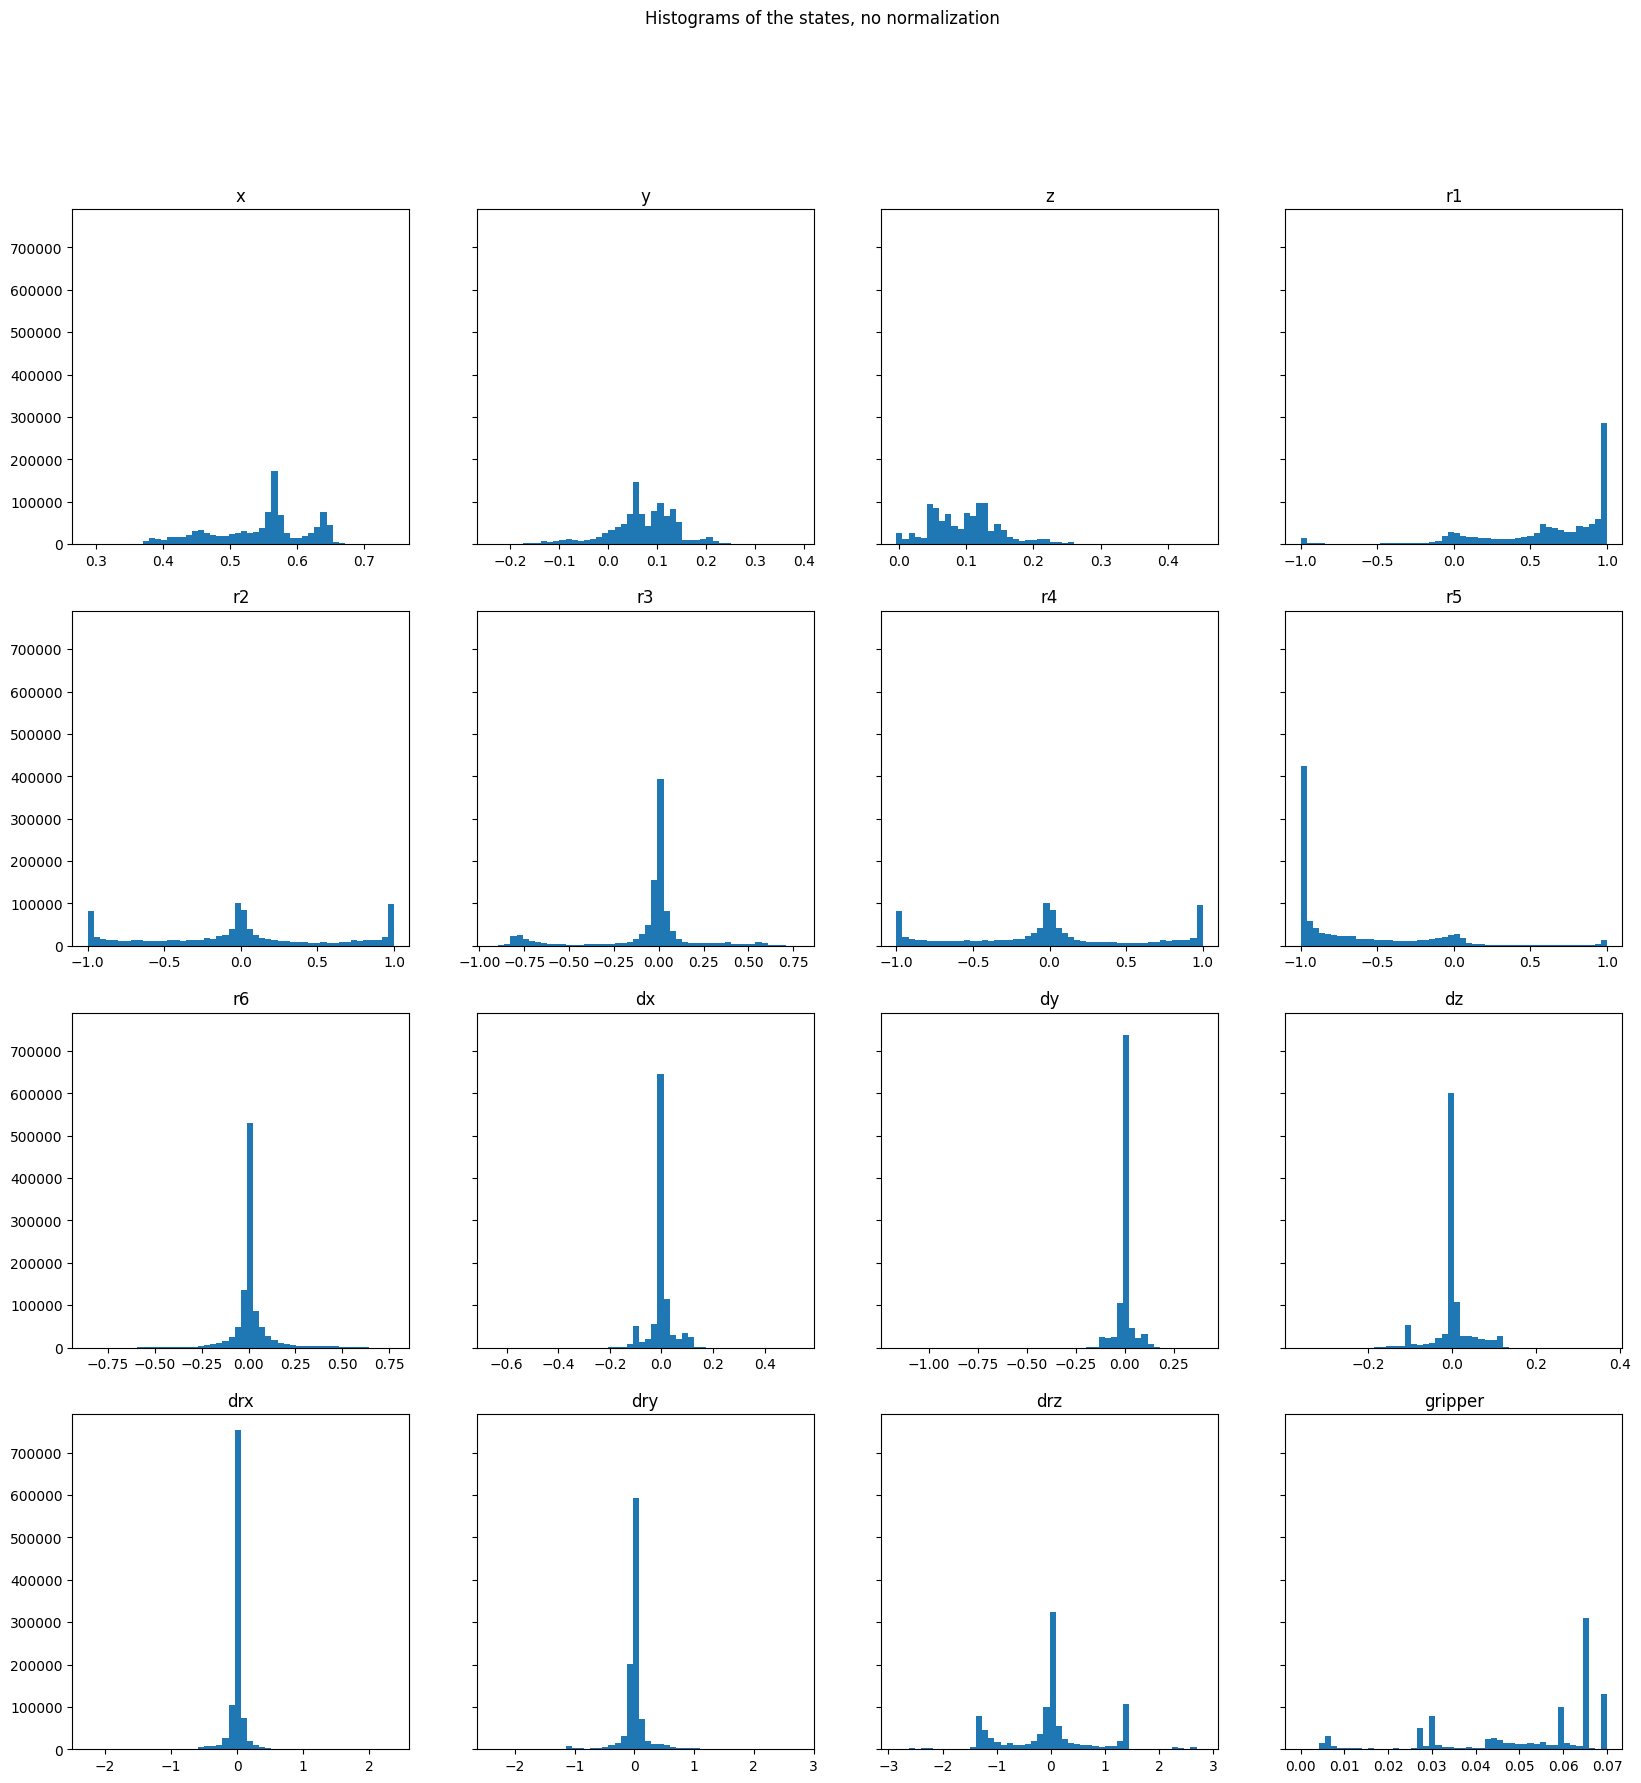

In [36]:
# Make histograms for each of the states
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(20, 20), sharey=True)

for i, name in enumerate(state_names):
    ax[i // 4, i % 4].hist(state_df[name], bins=50)
    ax[i // 4, i % 4].set_title(name)

fig.suptitle("Histograms of the states, no normalization")

In [38]:
# Look at the same but normalized
normalized_states = normalizer(state_df, key="robot_state", forward=True)
standardized_states = standardizer(state_df, key="robot_state", forward=True)

normalized_states.agg(["min", "max"])

,x,y,z,r1,r2,r3,r4,r5,r6,dx,dy,dz,drx,dry,drz,gripper
min,-1.000000,-1.179077,-1.000000,-1.000003,-1.0,-1.026451,-1.0,-1.000000,-1.346276,-1.0,-1.0,-1.00000,-1.0,-1.0,-1.035930,-1.0
max,1.200665,1.443209,2.344322,1.000000,1.0,1.079177,1.0,1.000009,1.000000,1.0,1.0,1.44472,1.0,1.0,1.029402,1.0


In [39]:
# Look at range of standardized states
standardized_states.agg(["min", "max"])

,x,y,z,r1,r2,r3,r4,r5,r6,dx,dy,dz,drx,dry,drz,gripper
min,-3.703532,-4.483130,-2.027602,-4.339918,-1.581669,-3.296536,-1.595153,-0.777400,-9.689527,-16.484350,-33.521706,-8.162034,-24.472349,-10.635840,-3.462572,-2.868937
max,3.042275,4.678827,6.802143,0.924803,1.755161,3.159005,1.766275,4.282496,8.604396,13.281826,11.435665,8.345874,25.771507,12.277394,3.455442,0.981861


Text(0.5, 0.98, 'Histograms of the states normalized')

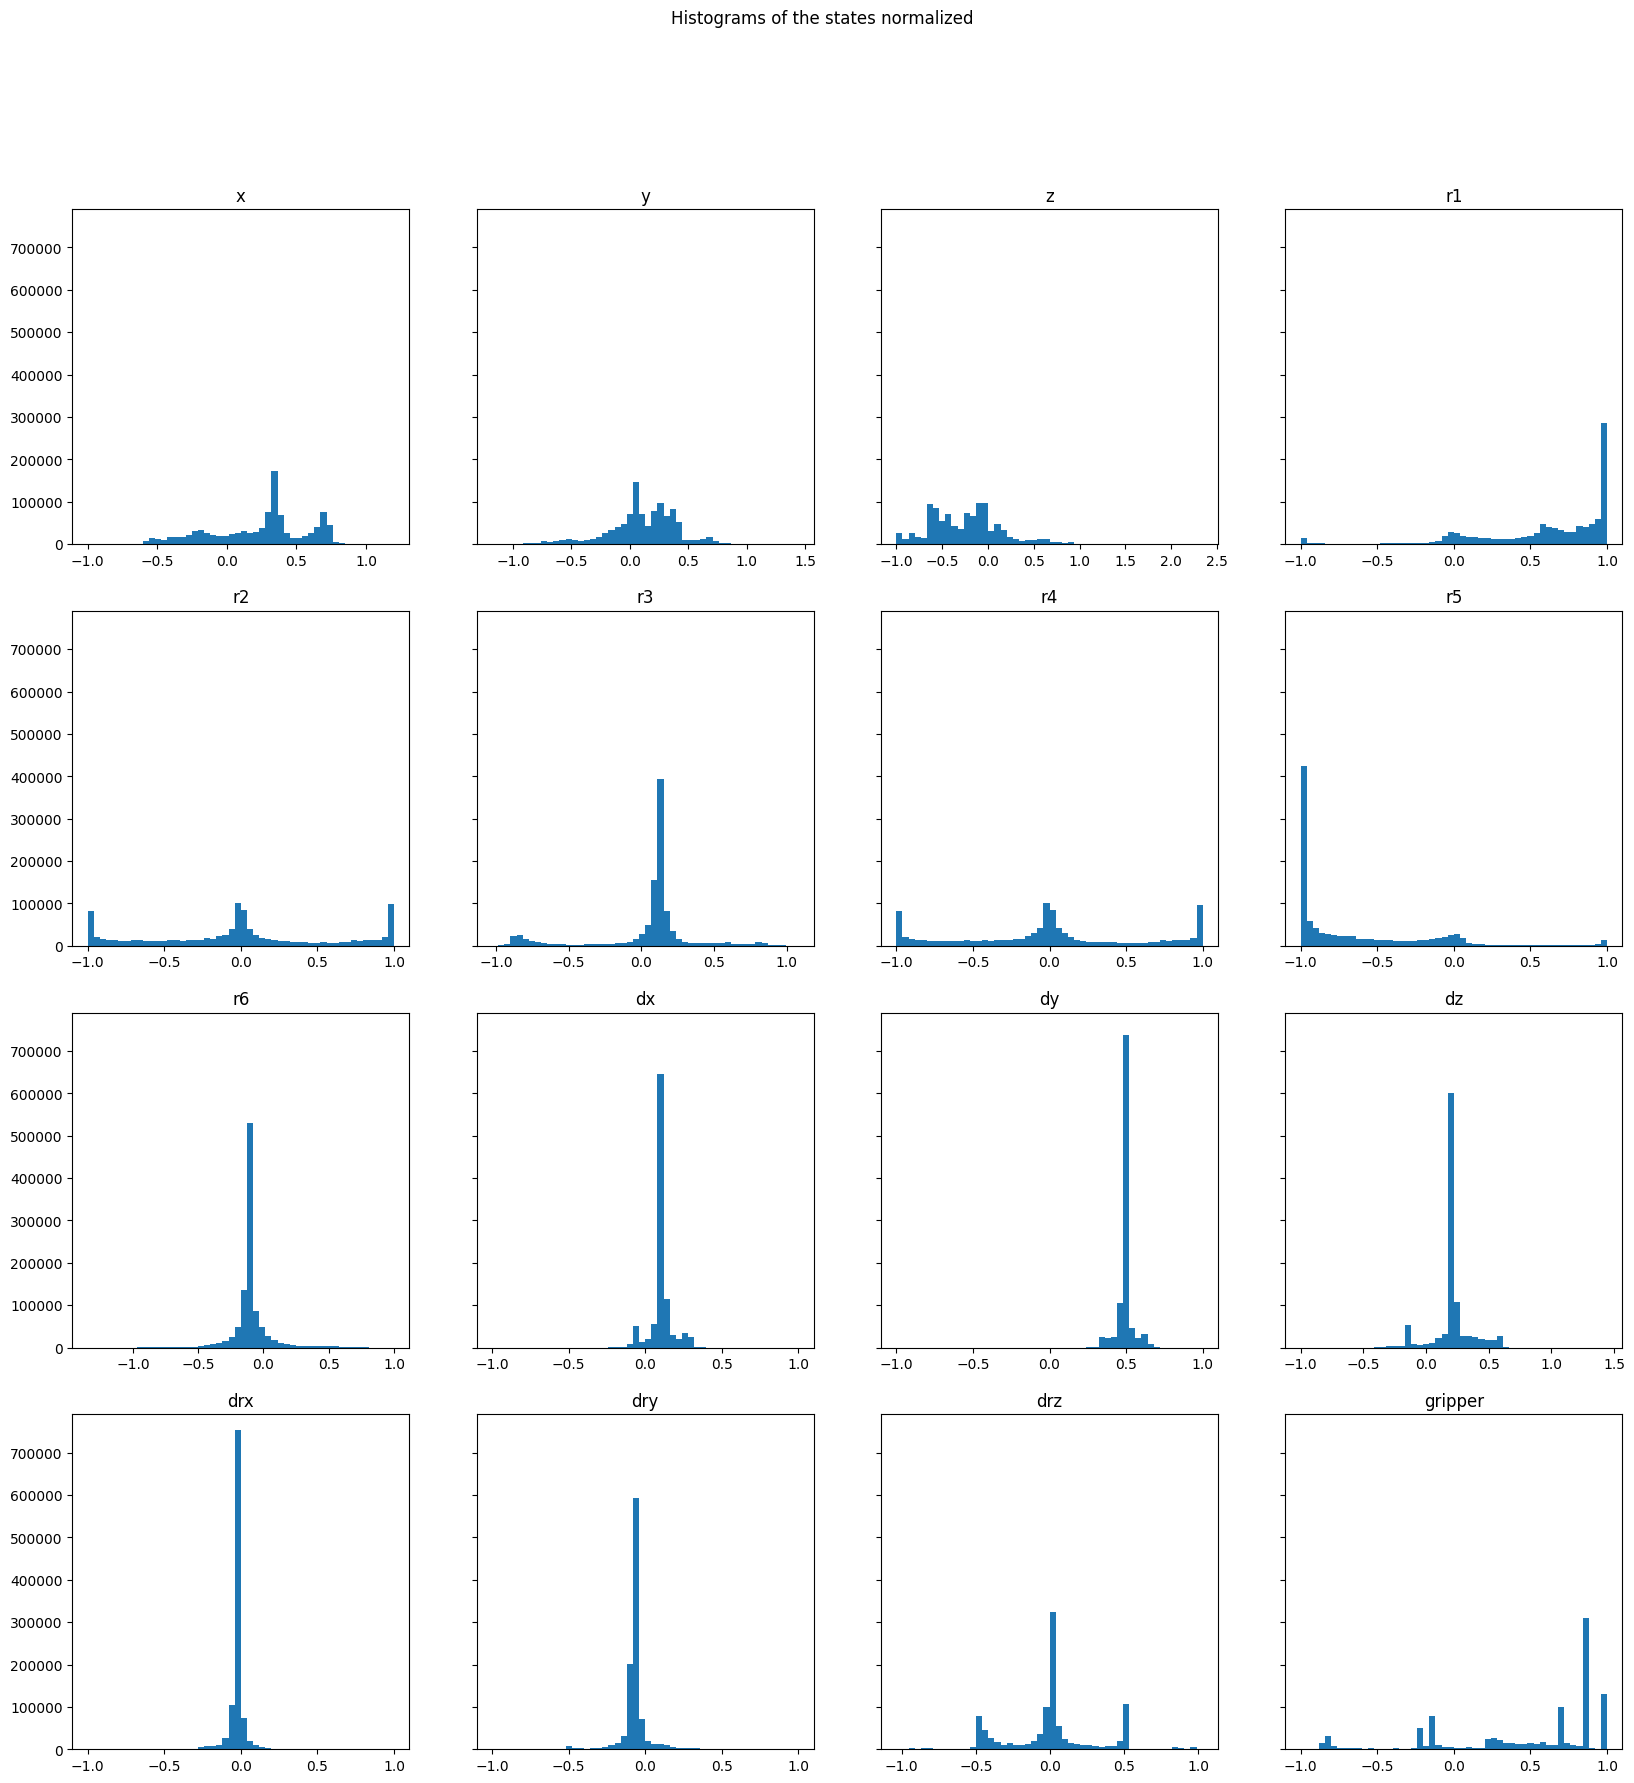

In [40]:
# Make histograms for each of the states normalized
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(20, 20), sharey=True)

for i, name in enumerate(state_names):
    ax[i // 4, i % 4].hist(normalized_states[name], bins=50)
    ax[i // 4, i % 4].set_title(name)

fig.suptitle("Histograms of the states normalized")

Text(0.5, 0.98, 'Histograms of the states standardized')

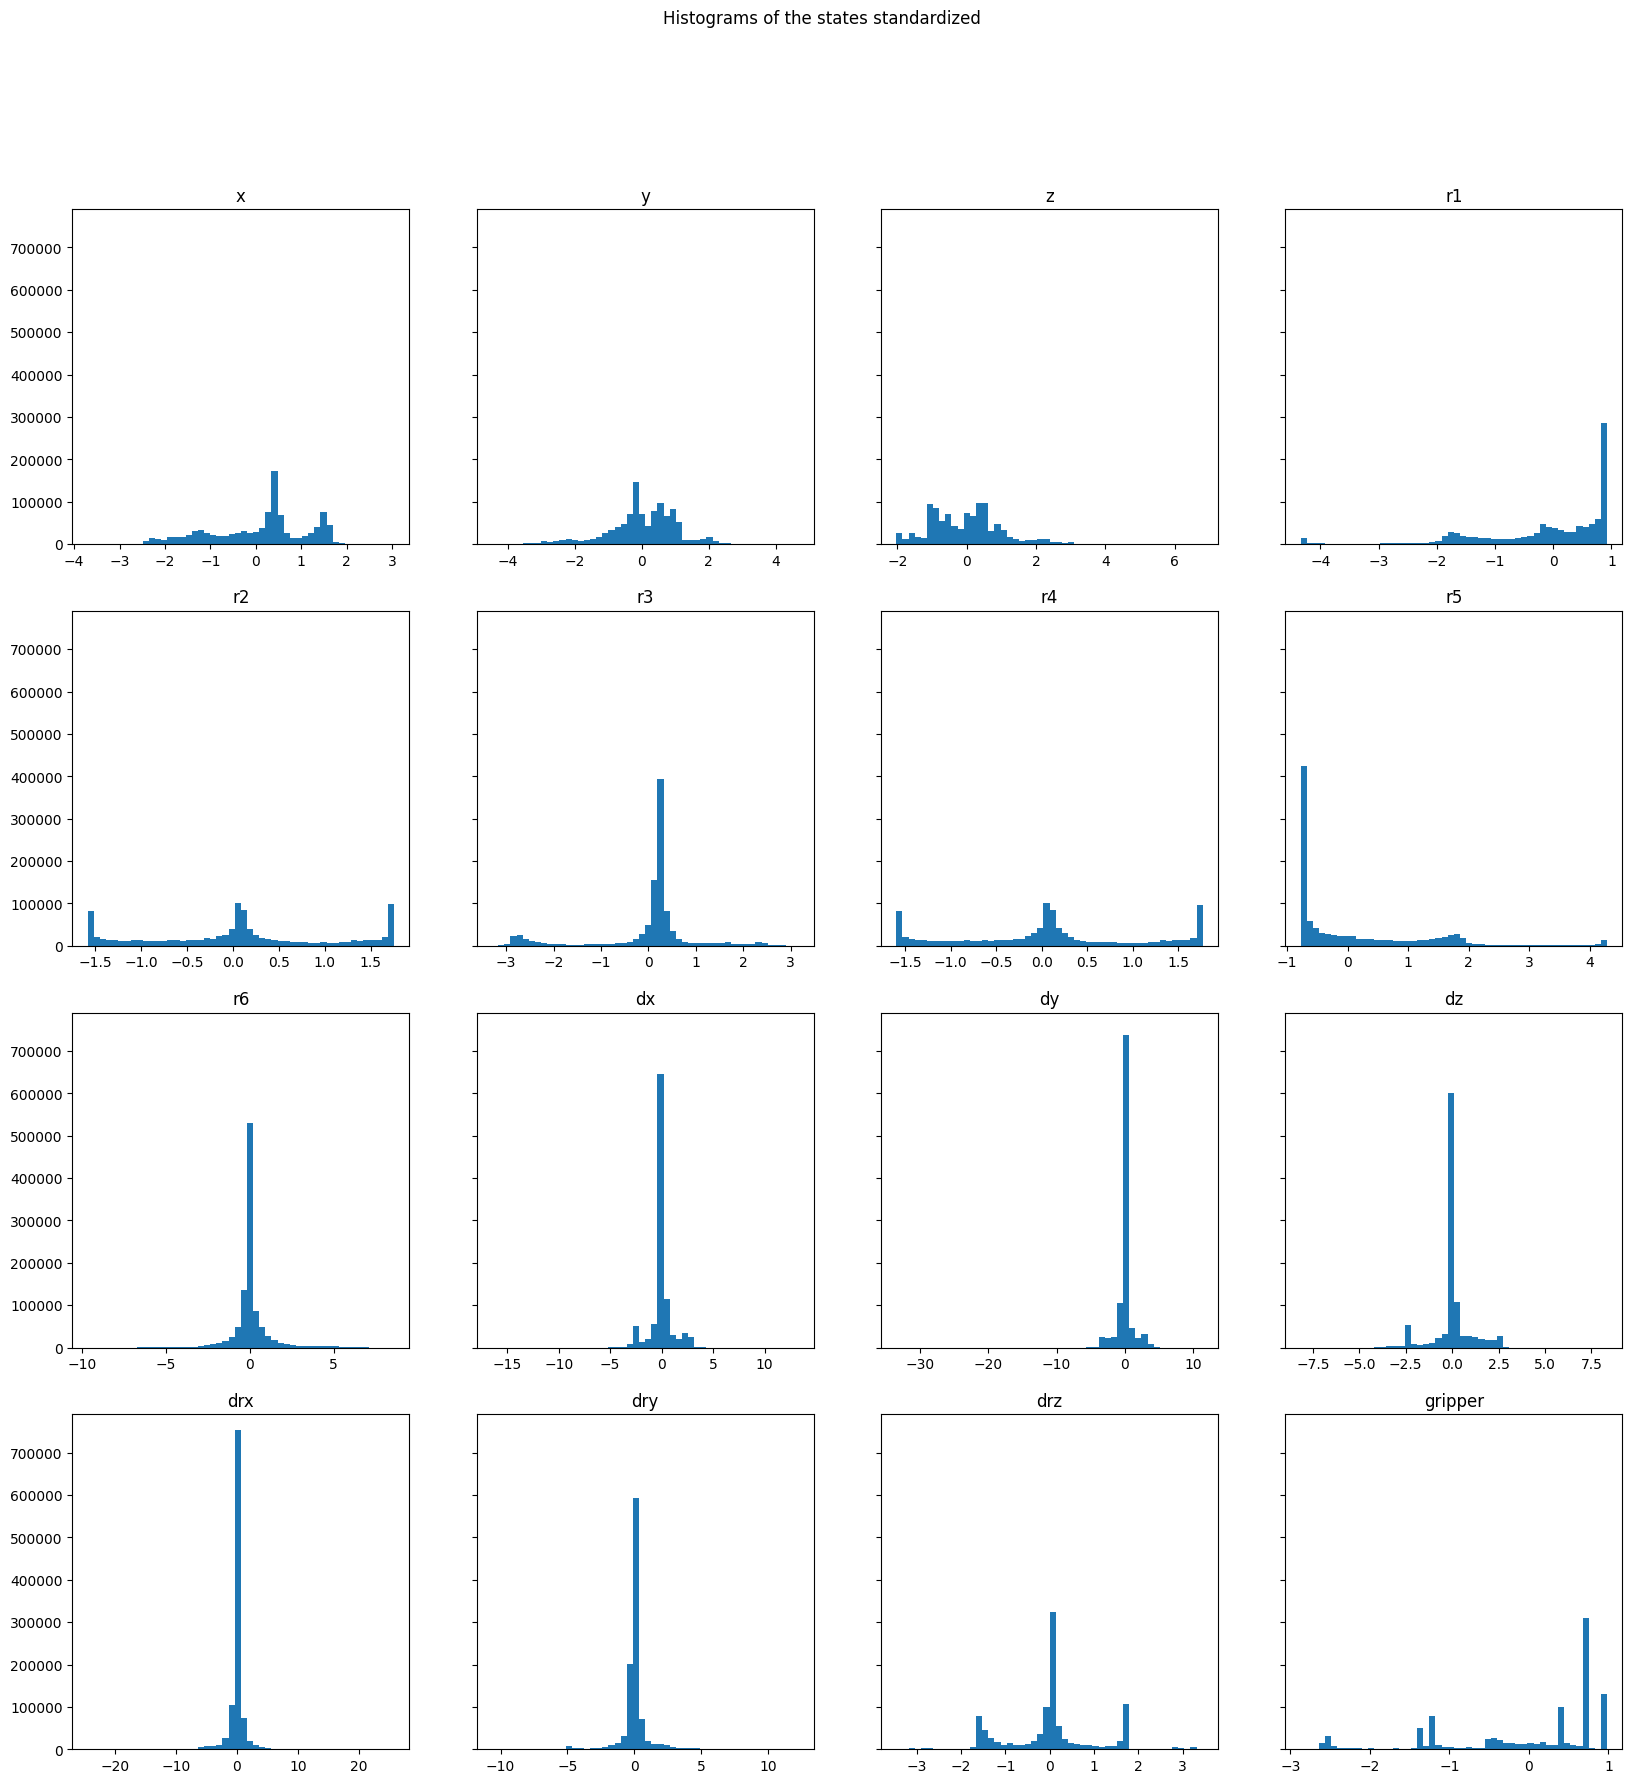

In [41]:
# Make histograms for each of the states standardized
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(20, 20), sharey=True)

for i, name in enumerate(state_names):
    ax[i // 4, i % 4].hist(standardized_states[name], bins=50)
    ax[i // 4, i % 4].set_title(name)

fig.suptitle("Histograms of the states standardized")